# Part 1: Introduction 

Amazon currently uses item-to-item collaborative filtering, which scales to massive data sets and produces high-quality recommendations in real time. This type of filtering matches each of the user's purchased and rated items to similar items, then combines those similar items into a recommendation list for the user.

This dataset contains information about the users and what rating they have given to certain electronic products on Amazon. The first column is User ID, second is Product ID, third is Rating and last is the TimeStamp

We will first build a kNN approach based model, then a CF based model.

# Part 2: Exploration and Preparation of Data 

## Importing libraries and Data 

In [1]:
import pandas as pd
import numpy as np
import Recommenders as Recommenders
import Evaluation as Evaluation
from IPython.core.interactiveshell import InteractiveShell
import math
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.externals import joblib
import scipy.sparse
from scipy.sparse import csr_matrix
import warnings; warnings.simplefilter('ignore')
from math import sqrt
from surprise import Dataset
from surprise import Reader
%matplotlib inline

D:\Anaconda\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
data = pd.read_csv("ratings.csv", header=None)

## Exploring the data

In [3]:
data.head()

,0,1,2,3
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [4]:
data.columns=["User ID", "Product ID", "Rating", "Time"]

In [5]:
data.head()

,User ID,Product ID,Rating,Time
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [6]:
data.drop("Time", axis=1, inplace = True)

In [7]:
data.head()

,User ID,Product ID,Rating
0,AKM1MP6P0OYPR,0132793040,5.0
1,A2CX7LUOHB2NDG,0321732944,5.0
2,A2NWSAGRHCP8N5,0439886341,1.0
3,A2WNBOD3WNDNKT,0439886341,3.0
4,A1GI0U4ZRJA8WN,0439886341,1.0


In [8]:
data.tail()

,User ID,Product ID,Rating
7824477,A2YZI3C9MOHC0L,BT008UKTMW,5.0
7824478,A322MDK0M89RHN,BT008UKTMW,5.0
7824479,A1MH90R0ADMIK0,BT008UKTMW,4.0
7824480,A10M2KEFPEQDHN,BT008UKTMW,4.0
7824481,A2G81TMIOIDEQQ,BT008V9J9U,5.0


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 3 columns):
User ID       object
Product ID    object
Rating        float64
dtypes: float64(1), object(2)
memory usage: 179.1+ MB


In [10]:
data.describe()

,Rating
count,7.824482e+06
mean,4.012337e+00
std,1.380910e+00
min,1.000000e+00
25%,3.000000e+00
50%,5.000000e+00
75%,5.000000e+00
max,5.000000e+00


In [11]:
len(data)

7824482

In [12]:
Users = data["User ID"].unique()
len(Users)

4201696

In [13]:
Products = data["Product ID"].unique()
len(Products)

476002

In [14]:
Ratings = data["Rating"].unique()
print("Max Rating is: ", Ratings.max())
print("Min Rating is: ", Ratings.min())

Max Rating is:  5.0
Min Rating is:  1.0


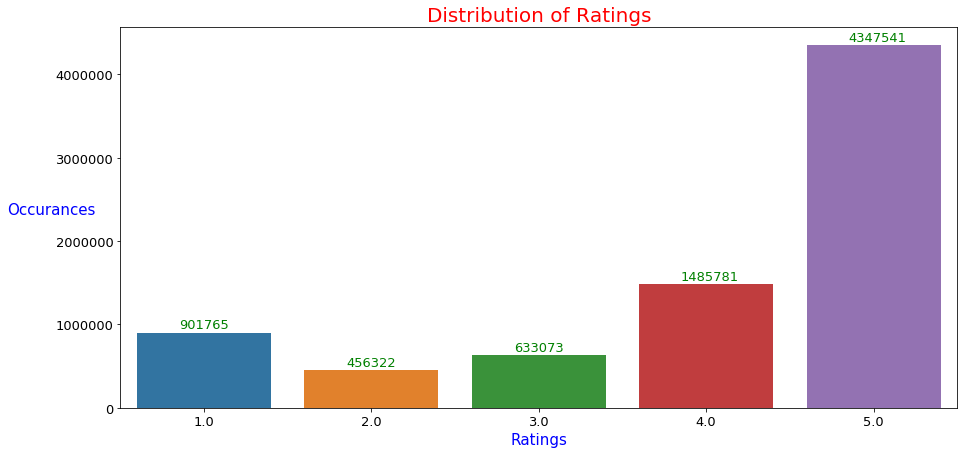

In [15]:
fig, (ax)=plt.subplots(figsize=(15,7))

sns.countplot(data["Rating"], ax=ax);
ax.set_xlabel('Ratings', fontsize=15, color='blue');
ax.set_ylabel('Occurances', fontsize=15, rotation =0, color='blue');
ax.set_title('Distribution of Ratings', fontsize=20, color='red');
ax.tick_params(labelsize=13);
for i in ax.patches:
    ax.text(i.get_x()+0.25, i.get_height()+50000, str(round((i.get_height()), 2)), fontsize=13, color='green');

We see that there are a lot of Ratings for "5", whereas the others are having significantly lesser occurances. We have also explored and found that there are a lot of data in hand and a similar amount of unique users and products. We shall now work on a subset of this data by selecting only the data where the users have rated more than 50 times

## Creating a subset 

In [16]:
most_rated = data.groupby('User ID').size().sort_values(ascending=False)[:20]
most_rated

User ID
A5JLAU2ARJ0BO     520
ADLVFFE4VBT8      501
A3OXHLG6DIBRW8    498
A6FIAB28IS79      431
A680RUE1FDO8B     406
A1ODOGXEYECQQ8    380
A36K2N527TXXJN    314
A2AY4YUOX2N1BQ    311
AWPODHOB4GFWL     308
A25C2M3QF9G7OQ    296
ARBKYIVNYWK3C     296
A22CW0ZHY3NJH8    292
A3EXWV8FNSSFL6    282
A38RMU1Y5TDP9     282
A3LGT6UZL99IW1    279
A2NOW4U7W3F7RI    277
A23GFTVIETX7DS    270
A3PD8JD9L4WEII    266
A17BUUBOU0598B    261
A3AYSYSLHU26U9    257
dtype: int64

In [17]:
counts = data['User ID'].value_counts()
data2 = data[data['User ID'].isin(counts[counts >= 50 ].index)]

In [25]:
print('Number of entries who have rated 50 or more products =', len(data2))
print('Number of unique users in final data = ', data2['User ID'].nunique())
print('Number of unique products in final data = ', data2['Product ID'].nunique())

Number of entries who have rated 50 or more products = 125871
Number of unique users in final data =  1540
Number of unique products in final data =  48190


In [19]:
data2.describe()

,Rating
count,125871.000000
mean,4.261339
std,1.062144
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


In [20]:
data2.head()

,User ID,Product ID,Rating
94,A3BY5KCNQZXV5U,0594451647,5.0
118,AT09WGFUM934H,0594481813,3.0
177,A32HSNCNPRUMTR,0970407998,1.0
178,A17HMM1M7T9PJ1,0970407998,4.0
492,A3CLWR1UUZT6TG,0972683275,5.0


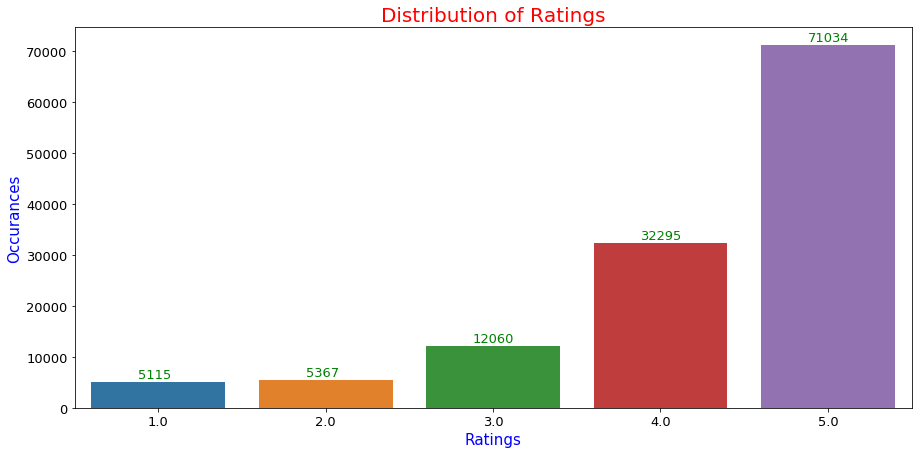

In [32]:
fig, (ax)=plt.subplots(figsize=(15,7))

sns.countplot(data2["Rating"], ax=ax);
ax.set_xlabel('Ratings', fontsize=15, color='blue');
ax.set_ylabel('Occurances', fontsize=15, rotation =90, color='blue');
ax.set_title('Distribution of Ratings', fontsize=20, color='red');
ax.tick_params(labelsize=13);
for i in ax.patches:
    ax.text(i.get_x()+0.28, i.get_height()+800, str(round((i.get_height()), 2)), fontsize=13, color='green');

As seen above, in the final dataset we are using, we find that occurances of rating 5 is the highest, but the imbalance is lesser as compared to earlier. Now we can move on to model building

# Part 3: Model Building 

## Creating ratings matrix

In [60]:
final_ratings_matrix = data2.pivot(index = 'User ID', columns ='Product ID', values = 'Rating').fillna(0)
print('Shape of final_ratings_matrix: ', final_ratings_matrix.shape)

given_num_of_ratings = np.count_nonzero(final_ratings_matrix)
print('given_num_of_ratings = ', given_num_of_ratings)
possible_num_of_ratings = final_ratings_matrix.shape[0] * final_ratings_matrix.shape[1]
print('possible_num_of_ratings = ', possible_num_of_ratings)
density = (given_num_of_ratings/possible_num_of_ratings)
density *= 100
print ('density: {:4.2f}%'.format(density))

Shape of final_ratings_matrix:  (1540, 48190)
given_num_of_ratings =  125871
possible_num_of_ratings =  74212600
density: 0.17%


In [61]:
final_ratings_matrix.head()

Product ID,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
User ID,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10AFVU66A79Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [62]:
# Matrix with one row per 'Product' and one column per 'user' for Item-based CF
final_ratings_matrix_T = final_ratings_matrix.transpose()
final_ratings_matrix_T.head()

User ID,A100UD67AHFODS,A100WO06OQR8BQ,A105S56ODHGJEK,A105TOJ6LTVMBG,A10AFVU66A79Y1,A10H24TDLK2VDP,A10NMELR4KX0J6,A10O7THJ2O20AG,A10PEXB6XAQ5XF,A10X9ME6R66JDX,...,AYOTEJ617O60K,AYP0YPLSP9ISM,AZ515FFZ7I2P7,AZ8XSDMIX04VJ,AZAC8O310IK4E,AZBXKUH4AIW3X,AZCE11PSTCH1L,AZMY6E8B52L2T,AZNUHQSHZHSUE,AZOK5STV85FBJ
Product ID,,,,,,,,,,,,,,,,,,,,,
0594451647,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0594481813,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0970407998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0972683275,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1400501466,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [64]:
#Split the data randomnly into test and train datasets
#Split the training and test data in the ratio 70:30
train_data, test_data = train_test_split(data2, test_size = 0.3, random_state=0)
train_data.head()

,User ID,Product ID,Rating
6595853,A2BYV7S1QP2YIG,B009EAHVTA,5.0
4738241,AB094YABX21WQ,B0056XCEAA,1.0
4175596,A3D0UM4ZD2CMAW,B004I763AW,5.0
3753016,AATWFX0ZZSE6C,B0040NPHMO,3.0
1734767,A1NNMOD9H36Q8E,B0015VW3BM,4.0


## Building the Popularity based model 

In [66]:
#Count of user_id for each unique product as recommendation score 
train_data_grouped = train.groupby('Product ID').agg({'User ID': 'count'}).reset_index()
train_data_grouped.rename(columns = {'User ID': 'score'},inplace=True)
train_data_grouped.head()

,Product ID,score
0,0594451647,1
1,0594481813,1
2,0970407998,2
3,0972683275,2
4,1400501466,4


In [67]:
#Sort the products on recommendation score 
train_data_sort = train_data_grouped.sort_values(['score', 'Product ID'], ascending = [0,1]) 
      
#Generate a recommendation rank based upon score 
train_data_sort['Rank'] = train_data_sort['score'].rank(ascending=0, method='first') 
          
#Get the top 5 recommendations 
popularity_recommendations = train_data_sort.head(5) 
popularity_recommendations 

,Product ID,score,Rank
30801,B0088CJT4U,144,1.0
19553,B003ES5ZUU,129,2.0
8647,B000N99BBC,120,3.0
30225,B007WTAJTO,112,4.0
30505,B00829TIEK,105,5.0


In [68]:
# Use popularity based recommender model to make predictions
def recommend(user_id):     
    user_recommendations = popularity_recommendations 
          
    #Add user_id column for which the recommendations are being generated 
    user_recommendations['User ID'] = user_id 
      
    #Bring user_id column to the front 
    cols = user_recommendations.columns.tolist() 
    cols = cols[-1:] + cols[:-1] 
    user_recommendations = user_recommendations[cols] 
          
    return user_recommendations 

In [70]:
#Randomly finding recommendations for user index at 20, 23, 2019 and 29102
find_recom = [20, 23, 2019, 29102]
for i in find_recom:
    print("Here is the recommendation for the userId: %d\n" %(i))
    print(recommend(i))    
    print("\n") 

Here is the recommendation for the userId: 20

       User ID  Product ID  score  Rank
30801       20  B0088CJT4U    144   1.0
19553       20  B003ES5ZUU    129   2.0
8647        20  B000N99BBC    120   3.0
30225       20  B007WTAJTO    112   4.0
30505       20  B00829TIEK    105   5.0


Here is the recommendation for the userId: 23

       User ID  Product ID  score  Rank
30801       23  B0088CJT4U    144   1.0
19553       23  B003ES5ZUU    129   2.0
8647        23  B000N99BBC    120   3.0
30225       23  B007WTAJTO    112   4.0
30505       23  B00829TIEK    105   5.0


Here is the recommendation for the userId: 2019

       User ID  Product ID  score  Rank
30801     2019  B0088CJT4U    144   1.0
19553     2019  B003ES5ZUU    129   2.0
8647      2019  B000N99BBC    120   3.0
30225     2019  B007WTAJTO    112   4.0
30505     2019  B00829TIEK    105   5.0


Here is the recommendation for the userId: 29102

       User ID  Product ID  score  Rank
30801    29102  B0088CJT4U    144   1.0
1

Popularity based models are very good at recommending products based only items, it doesn't consider user's behaviour.

## Collaborative Filtering Model 

In [71]:
df_CF = pd.concat([train_data, test_data]).reset_index()
df_CF.head()

,index,User ID,Product ID,Rating
0,6595853,A2BYV7S1QP2YIG,B009EAHVTA,5.0
1,4738241,AB094YABX21WQ,B0056XCEAA,1.0
2,4175596,A3D0UM4ZD2CMAW,B004I763AW,5.0
3,3753016,AATWFX0ZZSE6C,B0040NPHMO,3.0
4,1734767,A1NNMOD9H36Q8E,B0015VW3BM,4.0


In [73]:
#User-based Collaborative Filtering
# Matrix with row per 'user' and column per 'item' 
pivot_df = df_CF.pivot(index = 'User ID', columns ='Product ID', values = 'Rating').fillna(0)
pivot_df.shape
pivot_df.head()

Product ID,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
User ID,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10AFVU66A79Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [74]:
pivot_df['user_index'] = np.arange(0, pivot_df.shape[0], 1)
pivot_df.head()

Product ID,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8,user_index
User ID,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
A10AFVU66A79Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


In [75]:
pivot_df.set_index(['user_index'], inplace=True)

# Actual ratings given by users
pivot_df.head()

Product ID,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
user_index,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## SVD based recommendation system 

In [76]:
from scipy.sparse.linalg import svds
# Singular Value Decomposition
U, sigma, Vt = svds(pivot_df, k = 10)
# Construct diagonal array in SVD
sigma = np.diag(sigma)

In [77]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 

# Predicted ratings
preds_df = pd.DataFrame(all_user_predicted_ratings, columns = pivot_df.columns)
preds_df.head()

Product ID,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
0,0.002661,0.003576,0.004050,0.006906,0.003967,0.003073,0.005782,0.000568,0.014386,0.002708,...,6.108890e-04,0.044224,0.002919,0.060347,-0.002137,0.006751,0.001525,0.130951,0.059243,0.015014
1,0.002262,0.002505,0.005136,0.016517,0.007120,0.001438,0.013258,0.000335,-0.003781,0.001190,...,2.024793e-04,0.029213,0.000010,0.000244,-0.003111,-0.000621,0.004409,-0.039241,-0.006889,0.003696
2,-0.001600,-0.002502,0.002186,0.016742,0.006716,-0.002113,0.005805,0.003497,-0.005009,-0.001588,...,-3.240446e-04,0.009180,-0.002459,-0.016922,0.019936,-0.002483,-0.000155,-0.002889,-0.011522,-0.004525
3,0.002732,0.003867,0.001799,0.009395,0.004075,0.002778,0.003507,0.000095,0.007983,0.002381,...,6.031462e-04,-0.003369,0.003433,-0.003428,-0.000750,0.000119,0.002612,-0.015107,-0.006740,0.003276
4,0.000704,0.000085,0.002051,0.009664,0.004438,0.000335,0.005992,0.001056,-0.000369,0.000373,...,3.745108e-08,-0.001140,-0.000323,-0.025215,0.004700,-0.002170,0.001263,-0.048555,-0.016301,-0.003377


In [78]:
# Recommend the items with the highest predicted ratings

def recommend_items(userID, pivot_df, preds_df, num_recommendations):
      
    user_idx = userID-1 # index starts at 0
    
    # Get and sort the user's ratings
    sorted_user_ratings = pivot_df.iloc[user_idx].sort_values(ascending=False)
    #sorted_user_ratings
    sorted_user_predictions = preds_df.iloc[user_idx].sort_values(ascending=False)
    #sorted_user_predictions

    temp = pd.concat([sorted_user_ratings, sorted_user_predictions], axis=1)
    temp.index.name = 'Recommended Items'
    temp.columns = ['user_ratings', 'user_predictions']
    
    temp = temp.loc[temp.user_ratings == 0]   
    temp = temp.sort_values('user_predictions', ascending=False)
    print('\nBelow are the recommended items for user(user_id = {}):\n'.format(userID))
    print(temp.head(num_recommendations))

In [80]:
# Let's try for 13'th user and 5 recommendations
userID = 13
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 13):

                   user_ratings  user_predictions
Recommended Items                                
B003ES5ZUU                  0.0          1.870155
B00829THK0                  0.0          1.129815
B007WTAJTO                  0.0          1.035637
B004CLYEDC                  0.0          0.998599
B002R5AM7C                  0.0          0.928070


In [81]:
# Actual ratings given by the users
final_ratings_matrix.head()

Product ID,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
User ID,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10AFVU66A79Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [82]:
# Average ACTUAL rating for each item
final_ratings_matrix.mean().head()

Product ID
0594451647    0.003247
0594481813    0.001948
0970407998    0.003247
0972683275    0.012338
1400501466    0.012987
dtype: float64

In [83]:
# Predicted ratings 
preds_df.head()

Product ID,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
0,0.002661,0.003576,0.004050,0.006906,0.003967,0.003073,0.005782,0.000568,0.014386,0.002708,...,6.108890e-04,0.044224,0.002919,0.060347,-0.002137,0.006751,0.001525,0.130951,0.059243,0.015014
1,0.002262,0.002505,0.005136,0.016517,0.007120,0.001438,0.013258,0.000335,-0.003781,0.001190,...,2.024793e-04,0.029213,0.000010,0.000244,-0.003111,-0.000621,0.004409,-0.039241,-0.006889,0.003696
2,-0.001600,-0.002502,0.002186,0.016742,0.006716,-0.002113,0.005805,0.003497,-0.005009,-0.001588,...,-3.240446e-04,0.009180,-0.002459,-0.016922,0.019936,-0.002483,-0.000155,-0.002889,-0.011522,-0.004525
3,0.002732,0.003867,0.001799,0.009395,0.004075,0.002778,0.003507,0.000095,0.007983,0.002381,...,6.031462e-04,-0.003369,0.003433,-0.003428,-0.000750,0.000119,0.002612,-0.015107,-0.006740,0.003276
4,0.000704,0.000085,0.002051,0.009664,0.004438,0.000335,0.005992,0.001056,-0.000369,0.000373,...,3.745108e-08,-0.001140,-0.000323,-0.025215,0.004700,-0.002170,0.001263,-0.048555,-0.016301,-0.003377


In [84]:
# Average PREDICTED rating for each item
preds_df.mean().head()

Product ID
0594451647    0.001542
0594481813    0.002341
0970407998    0.002597
0972683275    0.011807
1400501466    0.004848
dtype: float64

In [85]:
rmse_df = pd.concat([final_ratings_matrix.mean(), preds_df.mean()], axis=1)
rmse_df.columns = ['Avg_actual_ratings', 'Avg_predicted_ratings']
print(rmse_df.shape)
rmse_df['item_index'] = np.arange(0, rmse_df.shape[0], 1)
rmse_df.head()

(48190, 2)


,Avg_actual_ratings,Avg_predicted_ratings,item_index
Product ID,,,
0594451647,0.003247,0.001542,0
0594481813,0.001948,0.002341,1
0970407998,0.003247,0.002597,2
0972683275,0.012338,0.011807,3
1400501466,0.012987,0.004848,4


In [86]:
## using math.sqrt function
RMSE = round(sqrt(((rmse_df.Avg_actual_ratings - rmse_df.Avg_predicted_ratings) ** 2).mean() ), 5)
print('\nRMSE SVD Model = {} \n'.format(RMSE))


RMSE SVD Model = 0.0033 



We will now take k = 5 and recommend top 5 products.

In [90]:
# Let us randomly take user no. 230 and 5 recommendations.
userID = 230
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 230):

                   user_ratings  user_predictions
Recommended Items                                
B003ES5ZUU                  0.0          0.551379
B0088CJT4U                  0.0          0.491720
B000N99BBC                  0.0          0.388806
B00829TIEK                  0.0          0.358646
B002R5AM7C                  0.0          0.337285


## Conclusion 

From what we see, the user based recommendation system wil be better since we are taking a subset of people who have rated a lot. We can then make use of the good amount of data about their behaviour and characteristics and using Item based collaborative filtering and SVD will be the best way to begin building a recommendation system for our particular subset. 